# General Idea
![ETL + Filtering](doc/integration_workflow_full_small.png)

## 1. Extract, Transform, Load from PharmGKB

In [1]:
from jPADP import jupyterPADP

jPADP = jupyterPADP(save_raw=False)

In [2]:
import pandas as pd
import itertools
import urllib
import urllib2
import json
from ipywidgets import interact
from Bio import Entrez
import networkx as nx
from nxpd import draw, nxpdParams
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
Entrez.email = 'vbursztyn@gmail.com'

In [4]:
BASE_PATH = 'data/'

URI_LABEL_API = 'https://api.pharmgkb.org/v1/data/label/%s?view=max'
jPADP.register_url(URI_LABEL_API, label='PharmGKB used to fetch diseases associated to each drug-gene pair')
jPADP.register_url('Entrez gene', label='NCBI used to fetch orthologs associated to our targeted genes (via Entrez lib)')
jPADP.register_url('Entrez nucleotide', label='NCBI used to download FASTA files (via Entrez lib)')

ORTHOLOG_TERM = 'ortholog_gene_%s[group]'

In [5]:
GENES_PATH = BASE_PATH + 'genes.tsv'
df_genes = pd.read_csv(GENES_PATH, sep='\t')
jPADP.load_dataset(GENES_PATH, label='Genes dataset downloaded from PharmGKB')

DRUGS_PATH = BASE_PATH + 'drugs.tsv'
df_drugs = pd.read_csv(DRUGS_PATH, sep='\t')
jPADP.load_dataset(DRUGS_PATH, label='Drugs dataset downloaded from PharmGKB')

LABELS_PATH = BASE_PATH + 'drugLabels.byGene.tsv'
df_relationships = pd.read_csv(LABELS_PATH, sep='\t')
jPADP.load_dataset(LABELS_PATH, label='Drug labels dataset downloaded from PharmGKB')

In [6]:
df_relationships.head(5)

,Gene ID,Gene Symbol,Label IDs,Label Names
0,PA267,ABCB1,PA166123409;PA166159586,EMA Label for aliskiren and ABCB1;HCSC Label f...
1,PA36144,ABI1,PA166127660;PA166127682;PA166127693;PA166129527,"HCSC Label for dasatinib and ABI1,BCR;HCSC Lab..."
2,PA24413,ABL1,PA166117941;PA166104914;PA166104926;PA16610533...,"EMA Label for bosutinib and ABL1,BCR;EMA Label..."
3,PA24414,ABL2,PA166104825,"FDA Label for valproic acid and ABL2,ASL,ASS1,..."
4,PA39,ADRB2,PA166104779,EMA Label for indacaterol and ADRB2


In [7]:
def get_drug_gene_tuples(drug_details, gene_details):
    drugs = drug_details.split(',')
    genes = gene_details.split(',')
    drug_gene_tuples = list()
    for drug_gene in list(itertools.product(drugs, genes)):
        drug_gene_tuples.append( (drug_gene[0], drug_gene[1]) )
    return drug_gene_tuples

In [8]:
%%time

df_drugs_genes = pd.DataFrame(columns=['Label ID', 'Drug Name', 'Gene Symbol'])

for values in df_relationships[['Label IDs', 'Label Names']].values:
    label_IDs = values[0].split(';')
    label_details = values[1].split(';')
    for i, label in enumerate(label_IDs):
        tokenized_details = label_details[i].split()
        drug_details = ' '.join(tokenized_details[(tokenized_details.index('for') + 1):tokenized_details.index('and')])
        gene_details = tokenized_details[tokenized_details.index('and') + 1]
        for drug_gene in get_drug_gene_tuples(drug_details, gene_details):
            df_drugs_genes = df_drugs_genes.append({ 'Label ID': label,
                                                     'Drug Name': drug_gene[0],
                                                     'Gene Symbol' : drug_gene[1] }, ignore_index=True)

CPU times: user 2.77 s, sys: 16.3 ms, total: 2.78 s
Wall time: 2.78 s


In [9]:
print 'Length: %s' %len(df_drugs_genes)

Length: 1297


In [10]:
df_drugs_genes = df_drugs_genes.drop_duplicates(subset=['Label ID', 'Drug Name', 'Gene Symbol'])
print 'Length: %s' %len(df_drugs_genes)

Length: 619


In [11]:
df_genes_proj = df_genes[['PharmGKB Accession Id', 'Name', 'Symbol', 'Cross-references']]

df_total = df_drugs_genes.merge(df_genes_proj, left_on='Gene Symbol', right_on='Symbol', how='outer').dropna()
df_total['NCBI'] = df_total['Cross-references'].apply(lambda x: x.split(',')[0])

df_total = df_total.drop(['Symbol', 'Cross-references'], axis=1)
df_total = df_total.rename(columns = {'PharmGKB Accession Id': 'Gene ID', 'Name': 'Gene Name'})

In [12]:
len(df_total)

619

In [13]:
df_total.head(5)

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI
0,PA166123409,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243
1,PA166159586,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243
2,PA166127660,dasatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006
3,PA166127682,imatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006
4,PA166127693,nilotinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006


In [14]:
df_drugs.head(2)

,PharmGKB Accession Id,Name,Generic Names,Trade Names,Brand Mixtures,Type,Cross-references,SMILES,InChI,Dosing Guideline,External Vocabulary
0,PA165820585,"1,7-dimethylxanthine","17X,""paraxanthine""",NaN,NaN,Drug,PubChem Compound:4687,NaN,NaN,No,NaN
1,PA451991,1-methyloxy-4-sulfone-benzene,NaN,NaN,NaN,Drug,"DrugBank:DB03033,""PDB:MSB"",""PubChem Compound:3...",COC1=CC=C(C=C1)S(=O)=O,InChI=1S/C7H8O3S/c1-10-6-2-4-7(5-3-6)11(8)9/h2...,No,NaN


In [15]:
for name in df_total['Drug Name']:
    if not len(df_drugs['Name'].loc[ df_drugs['Name'] == name ]):
        print name

aripiprazole lauroxil


In [16]:
df_total.loc[ df_total['Drug Name'] == 'aripiprazole lauroxil' ]

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI
257,PA166161219,aripiprazole lauroxil,CYP2D6,PA128,"cytochrome P450, family 2, subfamily D, polype...",NCBI Gene:1565


In [17]:
df_drugs_proj = df_drugs[['PharmGKB Accession Id', 'Name', 'Generic Names']]

df_total = df_total.merge(df_drugs_proj, left_on='Drug Name', right_on='Name', how='outer').dropna(subset=['Drug Name'])

df_total = df_total.drop(['Name'], axis=1)
df_total = df_total.rename(columns = {'PharmGKB Accession Id': 'Drug ID', 'Generic Names': 'Drug Generic Names'})

In [18]:
df_total.head(5)

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI,Drug ID,Drug Generic Names
0,PA166123409,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243,PA143487910,"Rasilez,""SPP 100"",""aliskiren"""
1,PA166159586,aliskiren,ABCB1,PA267,"ATP-binding cassette, sub-family B (MDR/TAP), ...",NCBI Gene:5243,PA143487910,"Rasilez,""SPP 100"",""aliskiren"""
2,PA166127660,dasatinib,ABI1,PA36144,abl-interactor 1,NCBI Gene:10006,PA162372878,"BMS-354825,""dasatinib"""
3,PA166127660,dasatinib,BCR,PA25321,breakpoint cluster region,NCBI Gene:613,PA162372878,"BMS-354825,""dasatinib"""
4,PA166104914,dasatinib,BCR,PA25321,breakpoint cluster region,NCBI Gene:613,PA162372878,"BMS-354825,""dasatinib"""


In [19]:
print '# of Labels: %s' %len(df_total)
print '# of Genes: %s' %len(df_total['Gene ID'].unique())
print '# of Drugs: %s' %len(df_total['Drug Name'].unique())

# of Labels: 619
# of Genes: 91
# of Drugs: 226


In [20]:
jPADP.modify_data(list(df_total.columns), list(df_total[u'Label ID'].values),\
                  label='Structured from drugs labels: genes and drugs associated to drug labels')

In [21]:
def fetch_label(label):
    print '.',
    try:
        jPADP.query_url(URI_LABEL_API, label,\
                        label='Fetching from online PharmGKB diseases associated to each drug-gene pair')
        fetched_label = json.load(urllib2.urlopen(URI_LABEL_API %(label)))
        return fetched_label['summaryMarkdown']['markdown']
    except:
        return 'Failed to fetch summary data for label %s' %(label)

In [22]:
%%time

df_total['Label Summary'] = df_total.apply(lambda row: fetch_label(row['Label ID']), axis=1)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## 2. Filtering Interface

Keyword examples: leukemia, breast cancer, lung cancer, cardiovascular, HIV, malaria.

In [23]:
jPADP.save(df_total, label='Pandas Dataframe before first filter')

In [24]:
df_filtered = None
global_kw = None

def filtering_interface(kw, field):
    global df_filtered
    global global_kw
    global_kw = kw
    jPADP.interaction_by_scientist(field, kw,\
                                   label='Scientists search by a disease or a drug and filter the associated genes')
    
    df_filtered = df_total[ df_total[field].str.contains(kw) ]
    filtered_genes = df_filtered['Gene Symbol'].unique()
    filtered_drugs = df_filtered['Drug Name'].unique()
    print '\n\n'.join(['%s drug labels found:' %(len(df_filtered)),
                     '%s genes: %s' %(len(filtered_genes), filtered_genes),
                     '%s drugs: %s' %(len(filtered_drugs), filtered_drugs)])
    print '\n==============================================================================================\n'
    print df_filtered['Label Summary']
    jPADP.modify_data(list(df_filtered.columns), list(df_filtered[u'Label ID'].values),\
                      label='Filtered genes after search interaction by scientist')

pd.options.display.max_colwidth = 250

field_options = df_total.columns.values.tolist()[1:]
field_options[0],field_options[-1] = field_options[-1],field_options[0]
interact(filtering_interface, kw='leukemia', field=field_options)

3 drug labels found:

3 genes: ['CYP2C19' 'CYP3A5' 'CYP3A4']

2 drugs: ['clopidogrel' 'ticagrelor']


364    The product monograph for clopidogrel (PLAVIX) states that CYP2C19 poor metabolizers may be at increased risk for experiencing cardiovascular events when taking the drug at recommended doses as compared to normal CYP2C19 metabolizers, and that an...
370    Ticagrelor is a platelet inhibitor used to reduce the risk of thrombotic cardiovascular events for patients with acute coronary syndrome. The FDA-approved drug label notes that thrombotic cardiovascular events did not depend on CYP2C19 loss of fu...
371    Ticagrelor is a platelet inhibitor used to reduce the risk of thrombotic cardiovascular events for patients with acute coronary syndrome. The FDA-approved drug label notes that thrombotic cardiovascular events did not depend on CYP2C19 loss of fu...
Name: Label Summary, dtype: object


In [25]:
cached = dict() #Avoid unnecessary querying

def fetch_orthologs(NCBI):
    search_term = ORTHOLOG_TERM %(NCBI.split(':')[1])
    if search_term in cached:
        return cached[search_term]
    
    search_results = dict()
    print 'Fetching orthologs with term: %s' %search_term
    jPADP.query_url('Entrez gene', search_term,\
                    label='For each targeted gene, retrieve from NCBI the number of species (genomes) having ortholog genes')
    handle = Entrez.esearch(db='gene', sort='relevance', retmax='10000', retmode='xml', term=search_term)
    orthologs = Entrez.read(handle)
    search_results['Count'] = orthologs['Count']
    search_results['IdList'] = orthologs['IdList']
    
    handle.close()    
    cached[search_term] = search_results   
    return search_results

In [26]:
df_filtered['Ortholog IDs'] = df_filtered.apply(lambda x: fetch_orthologs(x['NCBI']), axis=1)

Fetching orthologs with term: ortholog_gene_1557[group]
Fetching orthologs with term: ortholog_gene_1577[group]
Fetching orthologs with term: ortholog_gene_1576[group]


/Users/victorbursztyn/Documents/PESC/MSc/v1/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
orthologs_count = 0

for search_results in cached:
    orthologs_count += int(cached[search_results]['Count'])

print '************************************'
print '* Fetch and analyze %s orthologs? *' %orthologs_count
print '************************************'

************************************
* Fetch and analyze 16 orthologs? *
************************************


In [28]:
cached_2 = dict() #Avoid unnecessary querying (2)

def fetch_detailed_orthologs(NCBI, ortholog_ids):
    if NCBI in cached_2:
        return cached_2[NCBI]
    
    ortholog_ids = ortholog_ids['IdList']
    print 'Fetching %s orthologs for %s' %(len(ortholog_ids), NCBI)
    jPADP.query_url('Entrez gene', ','.join(ortholog_ids), label='For each targeted gene, fetch ortholog genes')
    handle = Entrez.efetch('gene', id=','.join(ortholog_ids), retmode='xml')
    fetch_results = Entrez.read(handle)
    
    handle.close()
    cached_2[NCBI] = fetch_results 
    return fetch_results

In [29]:
df_filtered['Ortholog Details'] = df_filtered.apply(lambda x:
                                                    fetch_detailed_orthologs(x['NCBI'], x['Ortholog IDs']),
                                                    axis=1)

Fetching 2 orthologs for NCBI Gene:1557
Fetching 9 orthologs for NCBI Gene:1577
Fetching 5 orthologs for NCBI Gene:1576


/Users/victorbursztyn/Documents/PESC/MSc/v1/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [30]:
jPADP.save(df_filtered, label='Pandas Dataframe with all ortholog details')

In [31]:
df_filtered.head(1)

,Label ID,Drug Name,Gene Symbol,Gene ID,Gene Name,NCBI,Drug ID,Drug Generic Names,Label Summary,Ortholog IDs,Ortholog Details
364,PA166127653,clopidogrel,CYP2C19,PA124,"cytochrome P450, family 2, subfamily C, polypeptide 19",NCBI Gene:1557,PA449053,NaN,"The product monograph for clopidogrel (PLAVIX) states that CYP2C19 poor metabolizers may be at increased risk for experiencing cardiovascular events when taking the drug at recommended doses as compared to normal CYP2C19 metabolizers, and that an...","{u'Count': u'2', u'IdList': [u'1557', u'101151965']}","[{u'Entrezgene_unique-keys': [{u'Dbtag_db': 'HGNC', u'Dbtag_tag': {u'Object-id': {u'Object-id_str': 'HGNC:2621'}}}, {u'Dbtag_db': 'LocusID', u'Dbtag_tag': {u'Object-id': {u'Object-id_id': '1557'}}}, {u'Dbtag_db': 'MIM', u'Dbtag_tag': {u'Object-id..."


## 3. Analytics Interface

In [33]:
all_genomes = set()

def add_orthologs_as_nodes():
    for detailed_orthologs in df_filtered['Ortholog Details']:
        for ortholog in detailed_orthologs:
            genome = ortholog['Entrezgene_source']['BioSource']['BioSource_org']['Org-ref']['Org-ref_taxname']
            all_genomes.add(genome)
            G.add_node(genome, color='#550000', style='filled', fillcolor='#ffaaaa')

In [34]:
def add_genes_as_nodes():
    for gene in df_filtered['Gene Symbol']:
        G.add_node(gene, color='#074600', style='filled', fillcolor='#92D18B')

In [35]:
def connect_genes_to_orthologs():
    for row in df_filtered[['Gene Symbol','Ortholog Details']].iterrows():
        gene = row[1]['Gene Symbol']
        for ortholog in row[1]['Ortholog Details']:
            genome = ortholog['Entrezgene_source']['BioSource']['BioSource_org']['Org-ref']['Org-ref_taxname']
            G.add_edge(genome, gene, color='#777777', style='dashed')

In [36]:
def add_drugs_as_nodes():
    for drug in df_filtered['Drug Name']:
        G.add_node(drug, color='#022735', style='filled', fillcolor='#6D92A0')

In [37]:
def connect_drugs_to_genes():
    for row in df_filtered[['Gene Symbol','Drug Name']].iterrows():
        gene = row[1]['Gene Symbol']
        drug = row[1]['Drug Name']
        G.add_edge(gene, drug, color='#777777', style='dashed')

In [38]:
def remove_low_degree_orthologs(threshold):
    low_degree_nodes = [node for node, degree in G.degree().items() if degree < threshold and node in all_genomes]
    G.remove_nodes_from(low_degree_nodes)

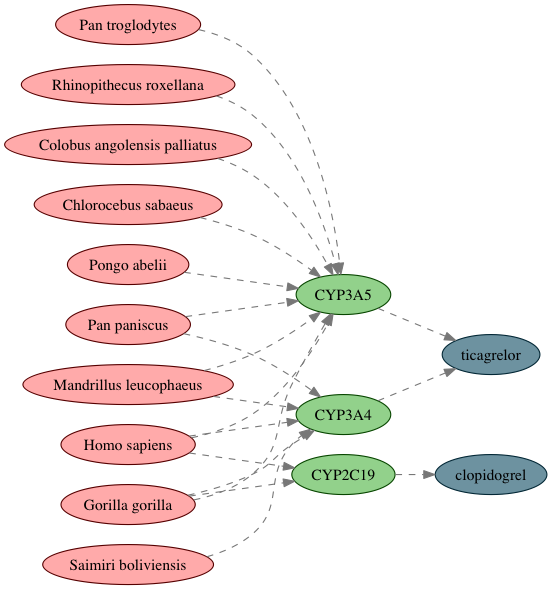

In [39]:
nxpdParams['show'] = 'ipynb'

G = None

def draw_network(threshold):
    global G
    G = nx.DiGraph()
    G.graph['rankdir'] = 'LR'
    G.graph['dpi'] = 80
    
    add_orthologs_as_nodes()
    add_genes_as_nodes()
    connect_genes_to_orthologs()
    add_drugs_as_nodes()
    connect_drugs_to_genes()
    if threshold:
        remove_low_degree_orthologs(threshold=threshold)
    return draw(G)

draw_network(threshold=0)

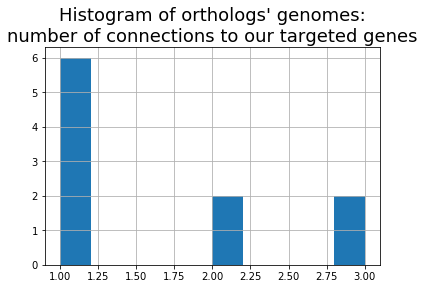

In [40]:
fig = plt.figure()
ortholog_degrees = [degree for node, degree in G.degree().items() if node in all_genomes]
pd.DataFrame(ortholog_degrees).hist()
plt.title('Histogram of orthologs\' genomes:\nnumber of connections to our targeted genes', fontsize=18)
plt.show()

Removing genomes with less than 1 connections to our targeted genes and drawing the network


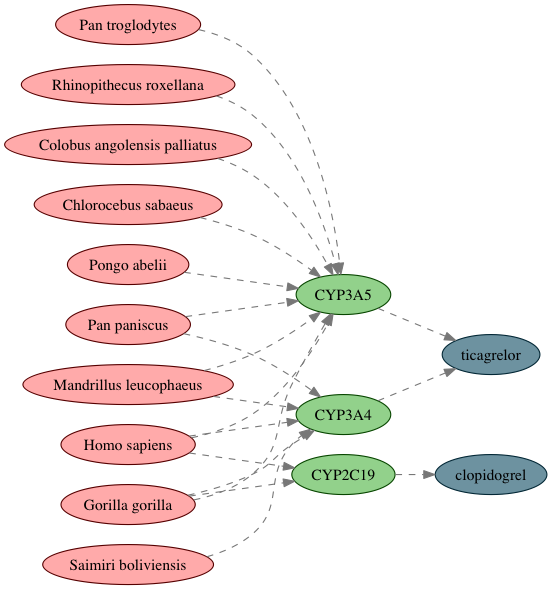

In [41]:
threshold_range = sorted(ortholog_degrees)

def node_removal_interface(threshold=threshold_range[-1]):
    jPADP.interaction_by_scientist('Node degree', threshold,\
                                   label='Scientists filter species (genomes) by the degree of sharing of ortholog genes')
    print 'Removing genomes with less than %s connections to our targeted genes and drawing the network' %threshold
    return draw_network(threshold=threshold)

interact(node_removal_interface, threshold=(1, threshold_range[-1]))

## 4. Input Consolidation

In [42]:
def fetch_FASTA(gene, FASTA_id):
    print '.',
    try:
        jPADP.query_url('Entrez nucleotide', FASTA_id,\
                    label='For each of the remaining genes, download its FASTA file')
        handle = Entrez.efetch('nucleotide', id=FASTA_id, rettype='fasta', retmode='text')
        FASTA = handle.fp.read()
        handle.close()
    except:
        FASTA = 'Unable to fetch FASTA for gene %s and id %s' %(gene, FASTA_id)
        print FASTA
    return FASTA

In [43]:
for row in df_filtered[['Gene Symbol']].drop_duplicates().values:
    gene = row[0]
    print 'Fetching FASTA for gene %s' %gene
    
    if not os.path.exists(os.path.join('out', gene)):
        os.makedirs(os.path.join('out', gene))
    
    search_string = '%s[Gene] AND mRNA[Filter] AND RefSeq[Filter]' %gene
    jPADP.query_url('Entrez nucleotide', search_string,\
                    label='For each of the remaining genes, download its FASTA file')
    ids = Entrez.read(Entrez.esearch(db='nucleotide', term=search_string))['IdList']
    
    for FASTA_id in ids:
        with open(os.path.join('out', gene, '%s.fasta'%FASTA_id), 'w') as f:
            f.write(fetch_FASTA(gene, FASTA_id))

Fetching FASTA for gene CYP2C19
. . . . . . . Fetching FASTA for gene CYP3A5
. . . . . . . . . . . . . . . . . . . . Fetching FASTA for gene CYP3A4
. . . . . . . . . . . . . .


In [44]:
jPADP.run_workflow('SciPhy', 'SINAPAD', 'input_file=Experiment_2_trial_1.FASTA',\
                   label='Calling SciPhy with all genes and orthologs associated to cardiovascular diseases')

In [45]:
jPADP.commit()

In [49]:
FASTA_str = ''
for FASTA_file in os.listdir(os.path.join('out', 'BCR')):
    if '.fasta' in FASTA_file:
        with open(os.path.join('out', 'BCR', FASTA_file), 'r') as f:
            FASTA_str += f.read()

In [52]:
with open(os.path.join('out', 'BCR', 'BCR_all.fasta'), 'w') as f:
    f.write(FASTA_str)

url = 'http://rest.sinapad.lncc.br/op/authentication/login-ldap'
params = urllib.urlencode({
  'username': 'kchiron',
  'password': 'password',
  'service': 'service'
})
headers = {'Accept' : 'application/xml'}
req = urllib2.Request(url, params, headers)
response = urllib2.urlopen(req).read()
print response

from poster.encode import multipart_encode
from poster.streaminghttp import register_openers

register_openers()
url = "http://rest.sinapad.lncc.br/op/file/upload"
data, headers = multipart_encode({"uuid" : uuid, "service" : "SERVICE", "project" : "PROJECT","file": open('file_test.txt', 'r+'), "override" : "false"})
headers.update({"Accept" : "application/json"})
request = urllib2.Request(url, data, headers)
print urllib2.urlopen(request).read()